# Wierszowa, rzadka eliminacja Gaussa w formacie CSR

**Maciej Skoczeń**, **Kacper Kafara**

grupa wtorek (A) 17:50

# Środowisko obliczeniowe

Procesor: Intel i7-9750H @ 2,6 GHz; 6 rdzeni fizycznych (12 log.)\
Pamięć RAM: 16 GB

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import subprocess
import matplotlib.pyplot as plt
import platform

from timeit import default_timer
from math import sqrt

Array = np.ndarray

## Funkcje pomocnicze

In [2]:
class Timer(object):
    def __init__(self):
        self._start_time = None
        self._stop_time = None

    def start(self):
        self._start_time = default_timer()

    def stop(self):
        self._stop_time = default_timer()

    @property
    def elapsed(self, val = None):
        if self._stop_time is None or self._start_time is None:
            return None
        elapsed = self._stop_time - self._start_time
        return elapsed
    

# mock impl
def is_int(value) -> bool:
    as_int = int(value)
    return value == as_int

###  Wczytywanie macierzy

wygenerowanej za pomocą dostarczonego skryptu `mass_matrix`, przepisanego do C++.

In [3]:
def input_matrix(octave_matrix, n, m, q=1):
    result = np.zeros((n*q, m*q), dtype=np.double)
    
    for elem in octave_matrix:
        m = re.match(r"\s*\((\d+),\s*(\d+)\)\s*->\s*(\d+\.\d+)\s*", elem)
        if m is not None:
            x, y, value = m.groups()
        elif len(elem) > 0:
            coord, value = elem.strip().split(' -> ')
            value = float(value)
            x, y = coord.split(',')
            x, y = x[1:], y.strip()[:-1]
        else:
            continue
        
        for i in range(q):
            for j in range(q):
                result[i*n + int(x) - 1, j*n + int(y) - 1] = float(value)
        
    return result

In [4]:
def load_octave_matrix(filename):
    with open(filename, "r") as file:
        return file.readlines()

In [5]:
data_dir = "../../output"

def resolve_path(matrix_type, width, height = None, generate = False):
    if height is None: height = width
    path = f"{data_dir}/{matrix_type}-{width}x{height}.txt"
    if os.path.isfile(path): return path
    elif not generate:
        raise FileNotFoundError(f"Matrix file {path} was not found in data dir.")
    else: 
        if platform.system() == "Windows":
            raise FileNotFoundError(f"Matrix file {path} was not found in data dir.\
                Automated generation is not supported on your platform: {platform.system()}.")

        if width != height:
            raise ValueError("Can only generate square matrix")
            
        generate_matrix(matrix_type, width)
        
        if os.path.isfile(path): return path
        else:
            print(path)
            raise RuntimeError("Failed to generate matrix")

In [6]:
def resolve_matrix(matrix_type, n, m, q = 1, generate = False):
    return input_matrix(
        load_octave_matrix(resolve_path(matrix_type, n, m, generate = generate)), n, m, q)

In [7]:
def generate_matrix(matrix_type, rank):
    if matrix_type not in {'iga', 'fem'}:
        raise ValueError(f"Invalid matrix type: {matrix_type}")
        
    if rank < 16 or not is_int(sqrt(rank)):
        raise ValueError(f"Invalid matrix rank: {rank}. Must be >= 16 and sqrt(rank) must be of type integer.")
        
    rank_root = int(sqrt(rank))
    
    if matrix_type == 'fem':
        for p in range(2, 5):
            double_nxx = rank_root - p + 1
            if double_nxx % 2 == 0 and double_nxx // 2 >= 2:
                nxx = double_nxx // 2
                pxx = p
                break
        else:
            raise RuntimeError(f"Failed to determine nxx, pxx for rank: {rank}")
    else:
        for p in range(2, 5):
            nxx = rank_root - p
            if nxx >= 2:
                pxx = p
                break
        else:
            raise RuntimeError(f"Failed to determine nxx, pxx for rank: {rank}")
    
    cwd = os.getcwd()
    os.chdir(os.getenv('SCRIPTS_DIR'))
    !./generate-matrix.sh cpp {matrix_type} {nxx} {pxx} 0
    os.chdir(cwd)

## Generowanie macierzy

In [8]:
A_n = 1024 # liczba wierszy i kolumn macierzy A
A = resolve_matrix('iga', A_n, A_n, generate=True)

B_n = 1600 # liczba wierszy i kolumn macierzy B
B = resolve_matrix('fem', B_n, B_n, generate=True)

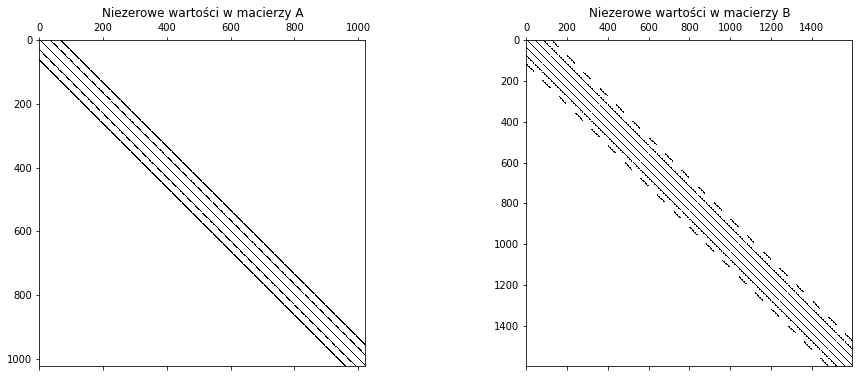

In [9]:
_, (ax_A, ax_B) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax_A.set_title('Niezerowe wartości w macierzy A')
ax_A.spy(A)
ax_B.set_title('Niezerowe wartości w macierzy B')
ax_B.spy(B)
plt.show()

## Implementacja formatu CSR

In [10]:
class CSRMatrix:
    def __init__(self, matrix: Array = None):
        self.non_zero_values_count = 0
        self.N = 0 # wysokość/szerokość macierzy
        self.column_indices = []
        self.values = []
        self.row_beginning_indices = []
        if matrix is not None:
            self.from_dense(matrix)
    
    def from_dense(self, matrix_dense: Array):
        self.N = matrix_dense.shape[0]
        for i in range(self.N): # wiersze
            self.row_beginning_indices.append(self.non_zero_values_count) # nowy wiersz
            for j in range(self.N): # kolumny
                if matrix_dense[i,j] != 0:
                    self.non_zero_values_count += 1
                    self.column_indices.append(j)
                    self.values.append(matrix_dense[i,j])
                    
        self.row_beginning_indices.append(self.non_zero_values_count)
            
    def cleanup(self):
        """Zakładamy, że w każdym wierszu istnieje niezerowa wartość"""
        i = 0
        last_modified_row = 0
        while i < self.non_zero_values_count:
            value = self.values[i]
            if abs(value) < 1e-9:
                self.values.pop(i)
                self.column_indices.pop(i)
                
                # aktualizacja wskaźników na wiersze
                
                # 1. znajdujemy wiersz
                for j in range(last_modified_row, self.N):
                    if i >= self.row_beginning_indices[j] and i < self.row_beginning_indices[j + 1]:
                        row_no = j
                        last_modified_row = j
                        break
                # 2. aktualizujemy indeksy początków wszystkich kolejnych wierszy
                for j in range(row_no + 1, self.N):
                    self.row_beginning_indices[j] -= 1
                self.non_zero_values_count -= 1
            else:
                i += 1
            
                

## Eliminacja Gaussa dla macierzy w formacie CSR

In [11]:
def sparse_gaussian_elimination(M: CSRMatrix, timer: Timer = None) -> None:
    N = M.N
    
    if timer: timer.start()
        

    for k in range(N): # iterowanie po przekątnej macierzy
        # znajdujemy wyraz na przekątnej
        k_row_start = M.row_beginning_indices[k]
        k1_row_start = M.row_beginning_indices[k + 1]
        
        # zakładam, że wartość na przekątnej jest niezerowa
        # wtedy wartość na przekątnej jest pierwszą niezerową
        # wartością w wierszu
        M_kk = M.values[k_row_start]
        for i in range(k_row_start, k1_row_start):
            M.values[i] /= M_kk
            
        # iterujemy po wierszach poniżej przekątnej
        for j in range(k + 1, N):
            first_non_zero_col_ind_j = M.column_indices[M.row_beginning_indices[j]]
            
            if first_non_zero_col_ind_j != k: continue # <=> M_jk == 0
                
            j_row_start = M.row_beginning_indices[j]
            j1_row_start = M.row_beginning_indices[j + 1]
                
            M_jk = M.values[j_row_start]
            
            k_iter = k_row_start
            j_iter = j_row_start
            while k_iter < k1_row_start and j_iter < j1_row_start:
                k_col = M.column_indices[k_iter]
                j_col = M.column_indices[j_iter]
                
                if k_col == j_col: # jeżeli ta sama kolumna, to aktualizujemy wartość
                    M.values[j_iter] -= M_jk * M.values[k_iter]
                    k_iter += 1
                    j_iter += 1
                elif k_col < j_col: # potrzebujemy wstawić wartość przed j_col
                    M.non_zero_values_count += 1
                    M.values.insert(j_iter, -(M_jk * M.values[k_iter]))
                    M.column_indices.insert(j_iter, M.column_indices[k_iter])
                    k_iter += 1
                    for row_index in range(j + 1, N):
                        M.row_beginning_indices[row_index] += 
                else: # jeżeli indeks góry jest > niż dołu, to wartość zostaje niezmieniona
                    j_iter += 1
            # usunięcie wszystkich zer z macierzy
            M.cleanup()
        
                
    if timer: timer.stop()

## Eliminacja Gaussa dla macierzy gęstej

In [12]:
def gaussian_elimination(
    A: Array,
    in_place: bool = False,
    timer: Timer = None
) -> Array:
    
    if not in_place: A = A.copy()
    
    if timer is not None:
        timer.start()

    n, _ = A.shape
    for i in range(n):
        A_i_i = A[i, i]
        for j in range(i + 1, n):
            factor = A[j, i] / A_i_i
            A[j, i] = 0
            for k in range(i + 1, n):
                A[j, k] -= factor * A[i, k]
                
    if timer is not None: timer.stop()
    if not in_place: return A

## Porównanie czasów wykonania eliminacji dla macierzy A (1024x1024)

In [13]:
n_tests = 1

sparse_exec_time_A = 0
dense_exec_time_A = 0

timer = Timer()

for test_no in range(n_tests):
    A_sparse = CSRMatrix(A)
    sparse_gaussian_elimination(A_sparse, timer)
    sparse_exec_time_A += timer.elapsed
    
sparse_exec_time_A /= n_tests
print(f'Średni czas wykonania dla eliminacji "rzadkiej": {sparse_exec_time_A:.5f}s')

for test_no in range(n_tests):
    gaussian_elimination(A, in_place=False, timer=timer)
    dense_exec_time_A += timer.elapsed

dense_exec_time_A /= n_tests
print(f'Średni czas wykonania dla eliminacji "gęstej": {dense_exec_time_A:.5f}s')

Średni czas wykonania dla eliminacji "rzadkiej": 9.54923s
Średni czas wykonania dla eliminacji "gęstej": 105.52044s


## Porównanie czasów wykonania eliminacji dla macierzy B (1600x1600)

In [ ]:
n_tests = 1

sparse_exec_time_B = 0
dense_exec_time_B = 0

for test_no in range(n_tests):
    B_sparse = CSRMatrix(B)
    sparse_gaussian_elimination(B_sparse, timer)
    sparse_exec_time_B += timer.elapsed
    
sparse_exec_time_B /= n_tests
print(f'Średni czas wykonania dla eliminacji "rzadkiej": {sparse_exec_time_B:.5f}s')

for test_no in range(n_tests):
    gaussian_elimination(B, in_place=False, timer=timer)
    dense_exec_time_B += timer.elapsed
    
dense_exec_time_B /= n_tests
print(f'Średni czas wykonania dla eliminacji "gęstej": {dense_exec_time_B:.5f}s')

Średni czas wykonania dla eliminacji "rzadkiej": 28.58339s
0
